In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_kddcup99
from functions import *
import pickle
import os

In [2]:
import sys
if 'sklearn' not in sys.modules:
   ! pip install scikit-learn

In [137]:

###### FUNCTIONS #######
def average(iterable):
    return sum(iterable)/len(iterable)

def labelToInt(label):
    """
    Let's define a map from Y (set of strings) into (0,size(Y)) for easier usage
    """
    uniqueLabels=list(np.unique(y))
    return uniqueLabels.index(label)


def deleteBytes(datum):
    x = datum[1]["x"]
    mask = [type(i) != bytes for i in x]
    datum[1]["x"] = np.asarray(x[mask])
    #print(x)
    #print(mask)
    return datum
    
def localPlusPlusInit(points, k, logDict=None): 
    #print('pointsshape: ', points.shape)
    '''
    Initialization kmeans ++
    points is a numpy array (n,dim)
    '''
    t0 = time()

    
    C=points[np.random.choice(points.shape[0])]#sample from array di punti ecc...
    C=C[np.newaxis, :]

    tSamples = []
    tCentroids = []
    
    for _ in range(k-1):
        #points is array (n, dim), C is array(g<=k, dim)
        #probs is array (n,1)
        t1=time()
        
        probs=np.min(np.sum((points[:,:,np.newaxis]-C.T[np.newaxis,:,:])**2, axis=1), axis=1).flatten()
        #probs=[min([sum((point-centroid)**2) for centroid in C]) for point in points] #numpyfy this, or numbafy if left base python
        probs=probs/np.sum(probs)
        nextCentroid=points[np.random.choice(points.shape[0], p=probs)][np.newaxis,:]
        #print('LE FORME',C.shape, nextCentroid.shape)

        t2=time()
        
        C=np.vstack((C, nextCentroid))

        t3=time()
        tSample = t2 -t1
        tCentroid = t3 - t2
        tSamples.append(tSample)
        tCentroids.append(tCentroid)
        

    tEnd=time()
    if logDict is not None:
        logDict["tSamples"] = tSamples
        logDict["tCentroids"] = tCentroids
        logDict["tTotal"] = tEnd - t0
    
    return C


def weightedAverage(group):
    """
    Function to compute the weighted average
    """
    weight_column='weights'
    groupby_column='clusterId'
    columns_to_average = group.columns.difference([weight_column, groupby_column])
    weighted_averages = group[columns_to_average].multiply(group[weight_column], axis=0).sum() / group[weight_column].sum()
    return weighted_averages


def localLloyds(points, k, C_init=None, weights=None, n_iterations=100, logDict=None):
    """
    function that does the Local Lloyds algorithm
    """
    t0 = time()
    
    #my_kMeansCosts = []
    tIterations = []
    
    df=pd.DataFrame(points)
    if weights is None:
        weights=np.ones(shape=len(points))
    #print('weights', weights)
    df['weights']=weights
    df['clusterId']=np.zeros(shape=len(points))
    if C_init is None:
        C=localPlusPlusInit(points, k)
    else:
        C=C_init
    #print('localPlusPluisInit: ', C)
    clusterId=np.argmin(np.sum((points[:,:,np.newaxis]-C.T[np.newaxis,:,:])**2, axis=1), axis=1)
    for iteration in range(n_iterations):
        t1=time()
        
        df['clusterId']=clusterId
        C_df=df.groupby('clusterId')\
            .apply(weightedAverage)\
            .reset_index()
        C_array=C_df[C_df.columns.difference(['weights', 'clusterId'])].reset_index(drop=True).to_numpy()
        clusterId=np.argmin(np.sum((points[:,:,np.newaxis]-C_array.T[np.newaxis,:,:])**2, axis=1), axis=1)
        #print(clusterId)

        #my_kMeansCosts.append(my_cost)
        t2 = time()
        
        tIteration = t2 - t1
        tIterations.append(tIteration)

    tEnd = time()
    tTotal = tEnd - t0
    
    if logDict is not None:
        #logDict["CostsKmeans"] = my_kMeansCosts
        logDict["tIterations"] = tIterations
        logDict["tTotal"] = tTotal
    
    return C_array   


def minmaxRescale(datum, minS, maxS):
    """
    Rescale a datum in [0,1]
    """
    mask = np.array(minS < maxS).astype(bool)
    feature = datum[1]["x"] 
    feature = (feature[mask] - minS[mask])/(maxS[mask] - minS[mask])
    return (datum[0], {"x": feature, "y": datum[1]["y"], "d2":datum[1]["d2"]}) 


def selectCluster(datum, C, updateDistances=True):
    """
    Associates a datum to its centroid and updates the distance if True
    dimC(k, len(datum))
    """
    distances = np.sum((datum[1]["x"] - C)**2, axis=1)
    print('distances: ',distances)
    clusterId = np.argmin(distances)
    if updateDistances is True:
        return (clusterId, {'x':datum[1]['x'], 'y':datum[1]['y'], 'd2':distances[clusterId]})
    else:
        return (clusterId, datum[1])


def updateCentroids(Rdd):
    """
    update centroids as 'centers of mass' of clusters
    """
    C=Rdd.mapValues(lambda xy: (xy['x'], 1))\
              .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1]))\
              .mapValues(lambda a:a[0]/a[1])\
              .values()\
              .collect() 
    C=np.array(C) #check later more carefully if causes some overhead
    return C


def updateDistances(Rdd, C):
    """
    update the Rdd with square distances from centroids, given Rdd with centroids already updated
    """
    def datumUpdate(datum, C):
        d2=np.sum((datum[1]['x']-C[datum[0]])**2)
        #return datum
        return (datum[0], {"x": datum[1]["x"], "y": datum[1]["y"], "d2":d2})
    Rdd=Rdd.map(lambda datum:datumUpdate(datum, C))
    return Rdd


def cost(Rdd):
    """
    calculate global cost of X,C from an Rdd with distances from centroids already updated
    """
    my_cost=Rdd.map(lambda datum : datum[1]['d2'])\
               .reduce(lambda a,b: a+b)
    return my_cost 


def kMeans(Rdd, C_init, maxIterations, logParallelKmeans=None):
    """
    kMeans in parallel (?)
    """
    
    t0 = time()
    
    my_kMeansCosts = []
    tIterations = []
    C=C_init

    for t in range(maxIterations):
        t1 = time()
        RddCached = Rdd.map(lambda datum: selectCluster(datum, C)).persist()
        # Now we compute the new centroids by calculating the averages of points belonging to the same cluster.
        # Need to check that all centroids are assigned to at least one point, otherwise k changes!!! Solutions?!
        C=updateCentroids(RddCached)
        my_cost = cost(RddCached)
        
        my_kMeansCosts.append(my_cost)
        t2 = time()
        
        tIteration = t2 - t1
        tIterations.append(tIteration)
        
        #RddCached.unpersist() bad for time efficiency, not necessary due to Python Garbage collector
        

    tEnd = time()
    tTotal = tEnd - t0
    
    if logParallelKmeans is not None:
        logParallelKmeans["CostsKmeans"] = my_kMeansCosts
        logParallelKmeans["tIterations"] = tIterations
        logParallelKmeans["tTotal"] = tTotal
        
    return C


def naiveInitFromSet(Rdd, k, logNaiveInit=None):
    """
    uniform sampling of k points from Rdd
    """
    t0 = time()
    
    kSubset=Rdd.takeSample(False, k)
    # Replacement is set to False to avoid coinciding centroids BUT no guarantees that in the original dataset all points are distinct!!! Check if causes problems in the algorithm (i.e. need to pre-filter) or it's ok
    C_init=np.array([datum[1]['x'] for datum in kSubset])

    tEnd = time()
    
    if logNaiveInit is not None:
        logNaiveInit["tTotal"] = tEnd - t0
        
    return C_init


def naiveInitFromSpace(k, dim):
    """
    #uniform drawing of k points from euclidean space
    #we assume the Rdd has been mapped into a [0,1]^dim space
    """
    C_init=np.random.uniform(size=(k,dim))
    return C_init


def parallelInit(Rdd, k, l, logParallelInit=None):
    """
    Parallel initialization
    """
    t0 = time()
    
    # initialize C as a point in the dataset
    C=naiveInitFromSet(Rdd, 1) 
    
    # associate each datum to the only centroid (computed before) and computed distances and cost
    Rdd=Rdd.map(lambda datum : (0, datum[1]))
    Rdd=updateDistances(Rdd, C).persist()
    my_cost=cost(Rdd)

    # number of iterations (log(cost))
    n_iterations=int(np.log(my_cost))
    if(n_iterations<1): n_iterations=1

    
    tSamples = []
    tCentroids = []
    CostInits = [my_cost]
    # iterative sampling of the centroids
    for _ in range(n_iterations):

        t1=time()
        # sample C' according to the probability
        C_prime=Rdd.filter(lambda datum : np.random.uniform()<l*datum[1]['d2']/my_cost)\
                   .map(lambda datum : datum[1]['x'])\
                   .collect()
        C_prime=np.array(C_prime)
        t2=time()

        # stack C and C', update distances, centroids, and cost
        if (C_prime.shape[0]>0):
            C=np.vstack((C, C_prime))
            Rdd=Rdd.map(lambda datum: selectCluster(datum, C)).persist()
            my_cost=cost(Rdd)
        t3=time()

        tSample = t2 -t1
        tCentroid = t3 - t2
        tSamples.append(tSample)
        tCentroids.append(tCentroid)
        CostInits.append(my_cost)
       
    #erase centroids sampled more than once 
    C=C.astype(float)
    C=np.unique(C, axis=0)
    Rdd=Rdd.map(lambda datum: selectCluster(datum, C))
    
    #compute weights of centroids (sizes of each cluster) and put them in a list whose index is same centroid index as C
    wx=Rdd.countByKey()
    weights=np.zeros(len(C))
    weights[[list(wx.keys())]]=[list(wx.values())]
    
    #subselection of k centroids from C, using local Lloyds algorithm with k-means++ initialization
    if C.shape[0]<=k:
        C_init=C
    else:
        C_init=localLloyds(C, k, weights=weights, n_iterations=100)

    tEnd = time()
    
    if logParallelInit is not None:
        logParallelInit["tSamples"] = tSamples
        logParallelInit["tCentroids"] = tCentroids
        logParallelInit["CostInit"] = CostInits
        logParallelInit["tTotal"] = tEnd - t0
        
    return C_init

def predictedCentroidsLabeler(C_expected, C_predicted):
    distMatrix=np.sum((C_expected[:,:,np.newaxis]-C_predicted.T[np.newaxis, :,:])**2,axis=1)
    #the labeler i-th entry j, tells that i-th centroid of C_expected is associated to j-th element of C_predicted
    labeler=np.argmin(distMatrix,axis=1)
    #square distance of element of C_expected to nearest point in C_predicted
    distances=np.sqrt(np.array(distMatrix[np.arange(len(distMatrix)),labeler]).astype(float))
    return labeler, distances

def nearestCentroidDistances(C):
    distMatrix=np.sum((C[:,:,np.newaxis]-C.T[np.newaxis, :,:])**2,axis=1)
    distMatrix+=np.diag(np.repeat(np.inf, distMatrix.shape[0]))
    #the labeler i-th entry j, tells that i-th centroid of C_expected is associated to j-th element of C_predicted
    labeler=np.argmin(distMatrix,axis=1)
    #square distance of element of C_expected to nearest point in C_predicted
    distances=np.sqrt(np.array(distMatrix[np.arange(distMatrix.shape[0]),labeler]).astype(float))
    return labeler, distances

# SET UP SPARK

In [4]:
# import the python libraries to create/connect to a Spark Session
from pyspark.sql import SparkSession

# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("My first spark application")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/05 14:33:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# create a spark context
sc = spark.sparkContext

# DESCRIBE THE DATA SET

In [6]:
data = fetch_kddcup99(return_X_y = True, percent10 = True) # default percent10=True


In [7]:
print("The number of samples is ", data[0].shape[0])
print("The dimensionality is ", data[0].shape[1])

The number of samples is  494021
The dimensionality is  41


Classes: 23
Samples total: 4898431
Dimensionality: 41
Features: discrete (int) or continuous (float)

The first containing a 2D array of shape (n_samples, n_features) with each row representing one sample and each column representing the features


The first 4 elements of the data set (letters, what are them)
Duration: The length (in seconds) of the connection.
Protocol Type: The type of protocol used, such as TCP, UDP, or ICMP.
Service: The network service on the destination, such as HTTP, FTP, or SMTP.
Flag: The status flag of the connection, such as SF (successful connection), REJ (connection rejected), etc.

In [8]:
# collect samples and features (target)
x = data[0]
y = data[1] 

In [9]:
# optional shuffling for better exploration of subset of dataset
shuffling=True
x
if shuffling:
    shuffled_indices = np.random.permutation(len(y))
    x=x[shuffled_indices]
    y=y[shuffled_indices]

In [10]:
# cut the data for memory reasons
subLen = 5000
x = x[:subLen,]
y = y[:subLen]

In [11]:
# cycle over num_slices to be run on cloud veneto on a .py

In [12]:
nSlice = None # IMPORTANT PARAMETER FOR NUMBER OF PARTITIONS
Rdd = sc.parallelize([(None, {"x": x[i],"y": y[i], "d2":None}) for i in range(len(y))], numSlices = nSlice)

In [13]:
Rdd.getNumPartitions() # check partitions

2

In the following cells, the attributes of the dataset:

In [14]:
attributes = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate"
]

Check the symbolic variables in the dataset to have only useful data

In [15]:
RddX = Rdd.map(lambda datum: datum[1]["x"]).persist()
typeElement = RddX.map(lambda x: [set([type(x[i])]) for i in range(len(x))])\
                  .reduce(lambda a, b: [a[i].union(b[i]) for i in range(len(a))])

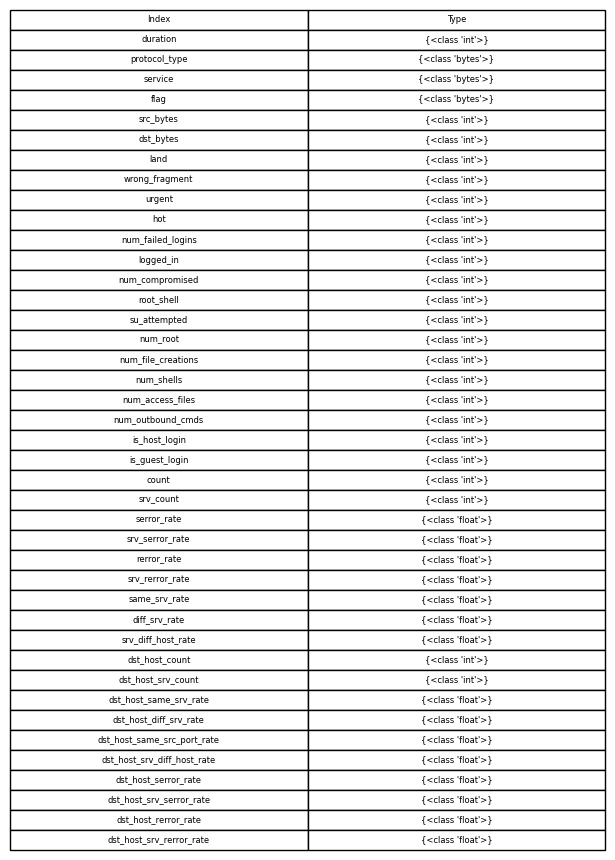

In [16]:
types_str = [str(t) for t in typeElement]
# Create a table
fig, ax = plt.subplots()

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table_data = [[attributes[i], types_str[i]] for i in range(len(types_str))]
column_labels = ("Index", "Type")
table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center')

# Adjust the table
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1.2, 1.2)


Look for the unique variables over the attributes using parallel processing

In [17]:
%%time
uniquesParallel = []
for i in range(41):
    s = RddX.map(lambda x: x[i])\
        .distinct()\
        .count()
    uniquesParallel.append(s)

RddX.unpersist()

CPU times: user 166 ms, sys: 57.1 ms, total: 223 ms
Wall time: 13.7 s


PythonRDD[1] at RDD at PythonRDD.scala:53

In [18]:
print("The number of uniques is", uniquesParallel)

The number of uniques is [76, 3, 47, 7, 347, 563, 1, 3, 1, 8, 1, 2, 2, 1, 1, 4, 2, 1, 2, 1, 1, 2, 306, 132, 15, 12, 19, 12, 45, 32, 43, 201, 190, 84, 59, 55, 35, 18, 9, 35, 30]


Look for the unique variables over the attributes in local

In [19]:
%%time
uniques = []
for i in range (x.shape[1]):
    k = (len(np.unique(x[:, i])))
    uniques.append(k)
print("The uniques are:", uniques)

The uniques are: [76, 3, 47, 7, 347, 563, 1, 3, 1, 8, 1, 2, 2, 1, 1, 4, 2, 1, 2, 1, 1, 2, 306, 132, 15, 12, 19, 12, 45, 32, 43, 201, 190, 84, 59, 55, 35, 18, 9, 35, 30]
CPU times: user 52.2 ms, sys: 952 µs, total: 53.2 ms
Wall time: 52.3 ms


It takes 4 times for to do it in parallel (explain what is better to use)

why running it a second time takes way more time?

In [20]:
%%time
RddY = Rdd.map(lambda datum: datum[1]["y"]).persist()

kTrue = RddY.distinct()\
        .count()

CPU times: user 5.95 ms, sys: 3.4 ms, total: 9.35 ms
Wall time: 431 ms


In [21]:
print("The true number of the classes is", kTrue)

The true number of the classes is 12


Unique number of labels in parallel

In [22]:
%%time
uniquesParallely = RddY.countByValue()
RddY.unpersist()

print("The y things are:", uniquesParallely)

The y things are: defaultdict(<class 'int'>, {b'smurf.': 2840, b'normal.': 956, b'neptune.': 1113, b'portsweep.': 7, b'warezclient.': 12, b'nmap.': 4, b'back.': 33, b'satan.': 14, b'ipsweep.': 9, b'teardrop.': 9, b'pod.': 2, b'buffer_overflow.': 1})
CPU times: user 2.19 ms, sys: 2.11 ms, total: 4.3 ms
Wall time: 165 ms


In [23]:
yUnique = [a.decode('utf-8') for a in uniquesParallely.keys()]
xUnique = list(uniquesParallely.values())

Plot of the count of the ocurency of the uniques of label and attributes

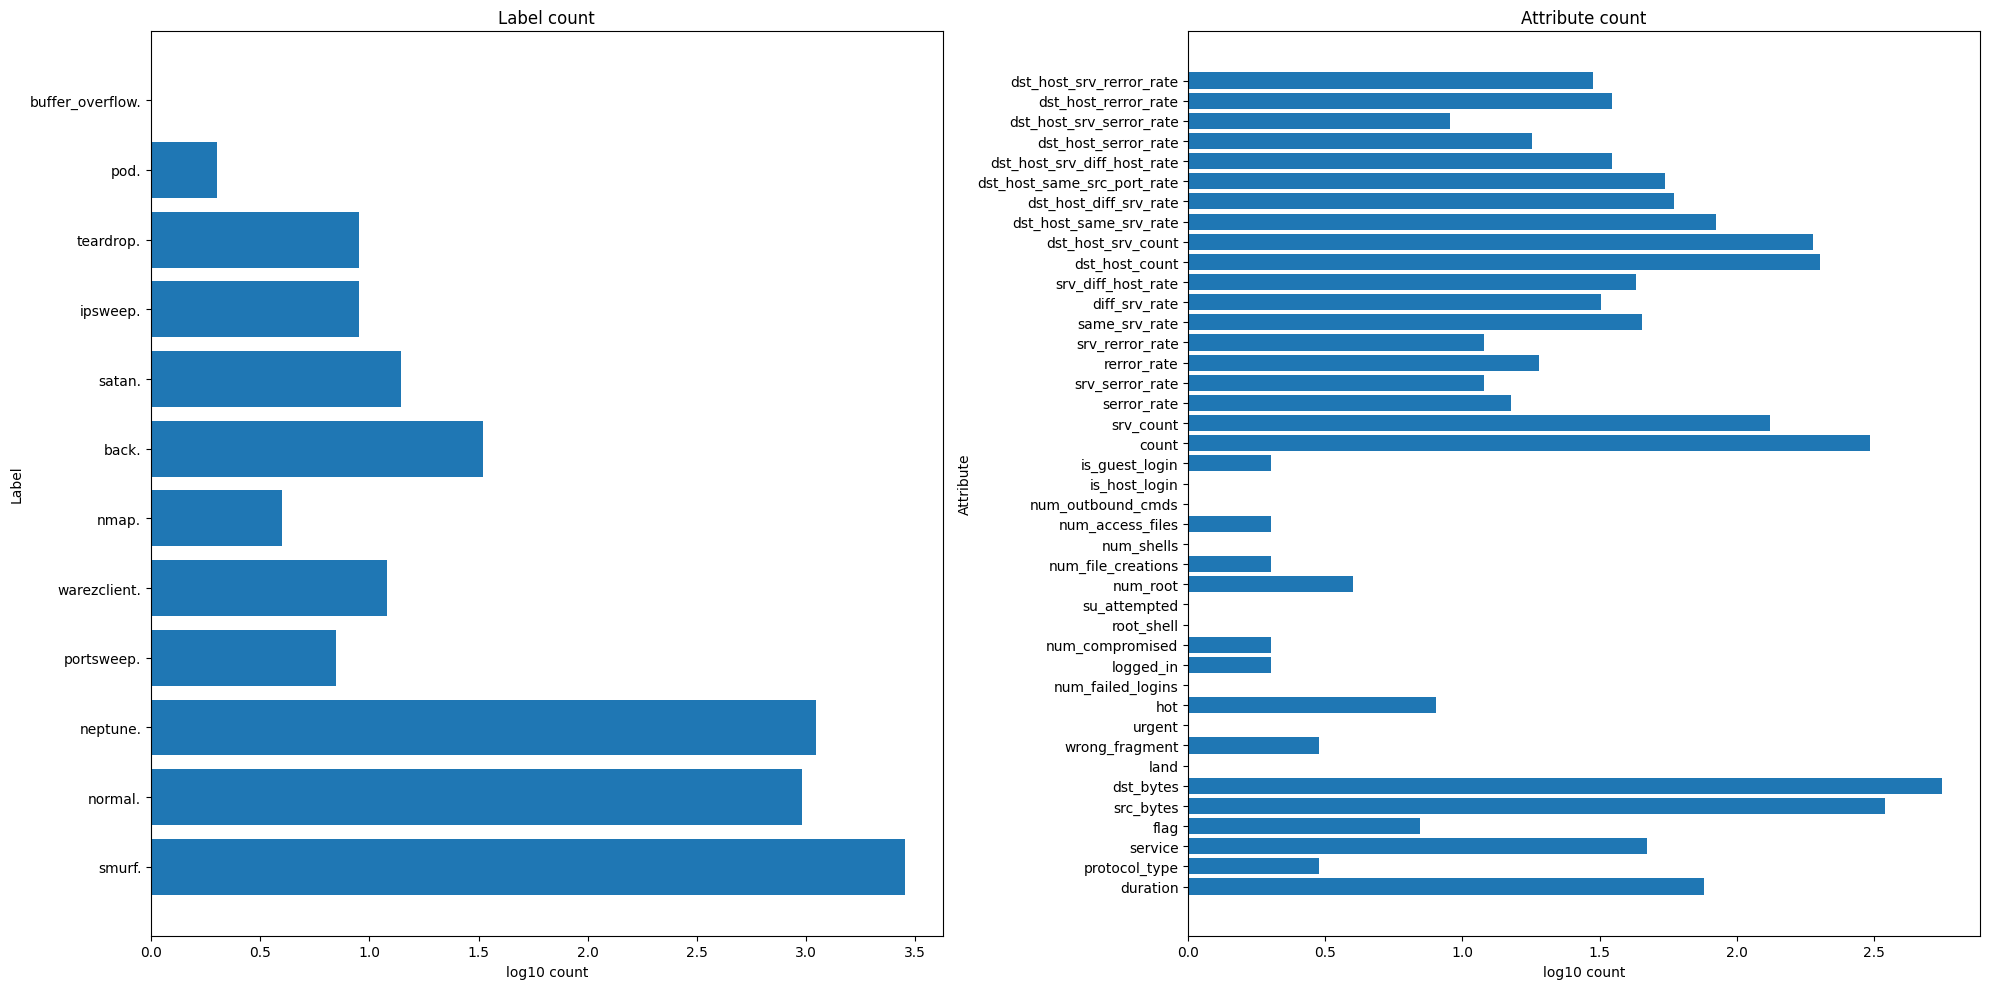

In [24]:
# add log 10 the ax and npt the count
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].barh(yUnique, np.log10(xUnique))
ax[0].set_xlabel("log10 count")
ax[0].set_ylabel("Label")
ax[0].set_title("Label count")
ax[1].barh(attributes, np.log10(uniquesParallel))
ax[1].set_xlabel("log10 count")
ax[1].set_ylabel("Attribute")
ax[1].set_title("Attribute count")
fig.tight_layout()

In [25]:
Rdd = Rdd.map(deleteBytes)\
         .persist()

In [26]:
numberColumns = len([i for i in typeElement if i != set([bytes])])
print("The number of columns (dimensionality) after filtering the bytes is", numberColumns)

The number of columns (dimensionality) after filtering the bytes is 38


# PARALLEL PART

In [27]:
%%time
maxS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.maximum(a, b))
minS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.minimum(a, b))

Rdd = Rdd.map(lambda datum: minmaxRescale(datum, minS, maxS))\
         .persist()

CPU times: user 5.68 ms, sys: 3.73 ms, total: 9.41 ms
Wall time: 823 ms


In [28]:
%%time

logParallelInit = {}
logParallelKmeans = {}

k=kTrue
l=k*2 # rescaling probability to have more centroids than k

# inizialize the centroids with kmeans parallel and compute C after the iterations
C_init = parallelInit(Rdd, k, l, logParallelInit)
C = kMeans(Rdd, C_init, 15, logParallelKmeans)
Rdd=Rdd.map(lambda datum: selectCluster(datum, C))

CPU times: user 1.1 s, sys: 52.3 ms, total: 1.16 s
Wall time: 45.5 s


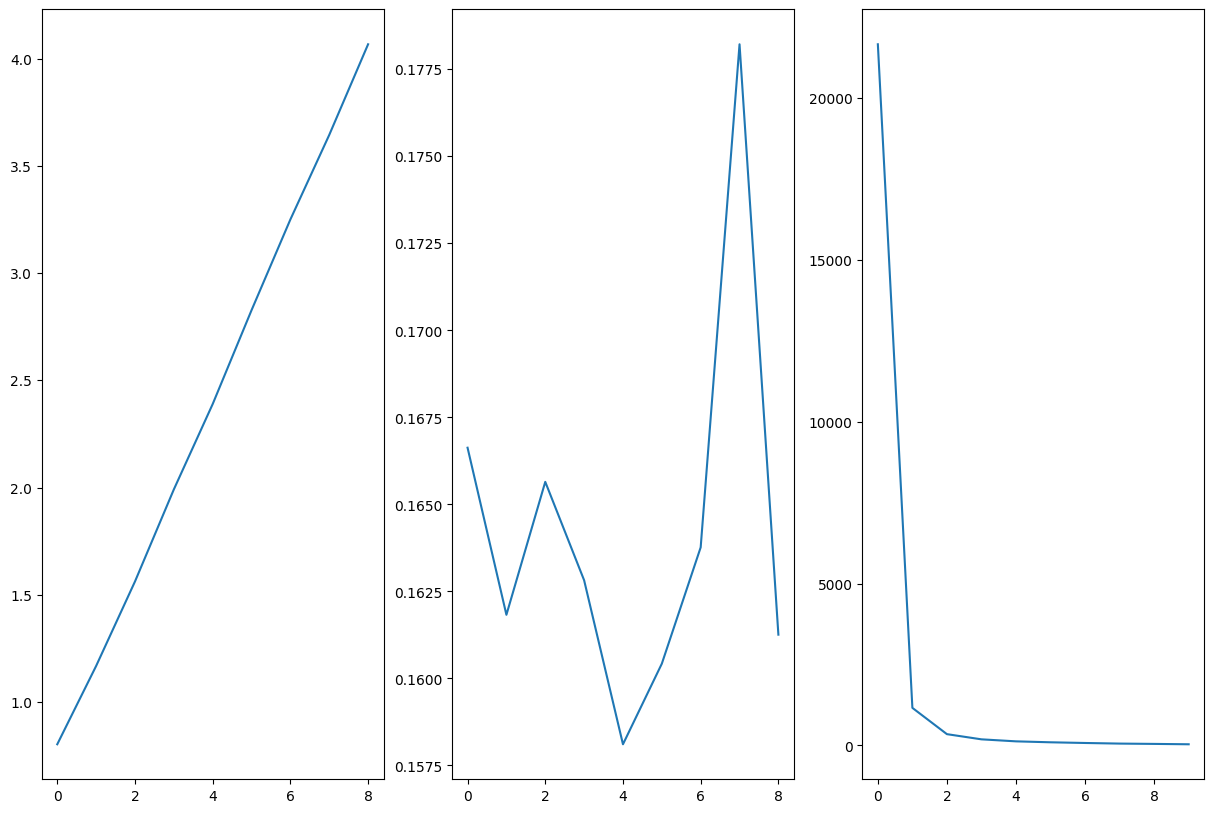

In [29]:
fig, ax=plt.subplots(1,3, figsize=(15,10))
ax[0].plot(logParallelInit["tCentroids"])
ax[1].plot(logParallelInit["tSamples"])
ax[2].plot(logParallelInit["CostInit"])

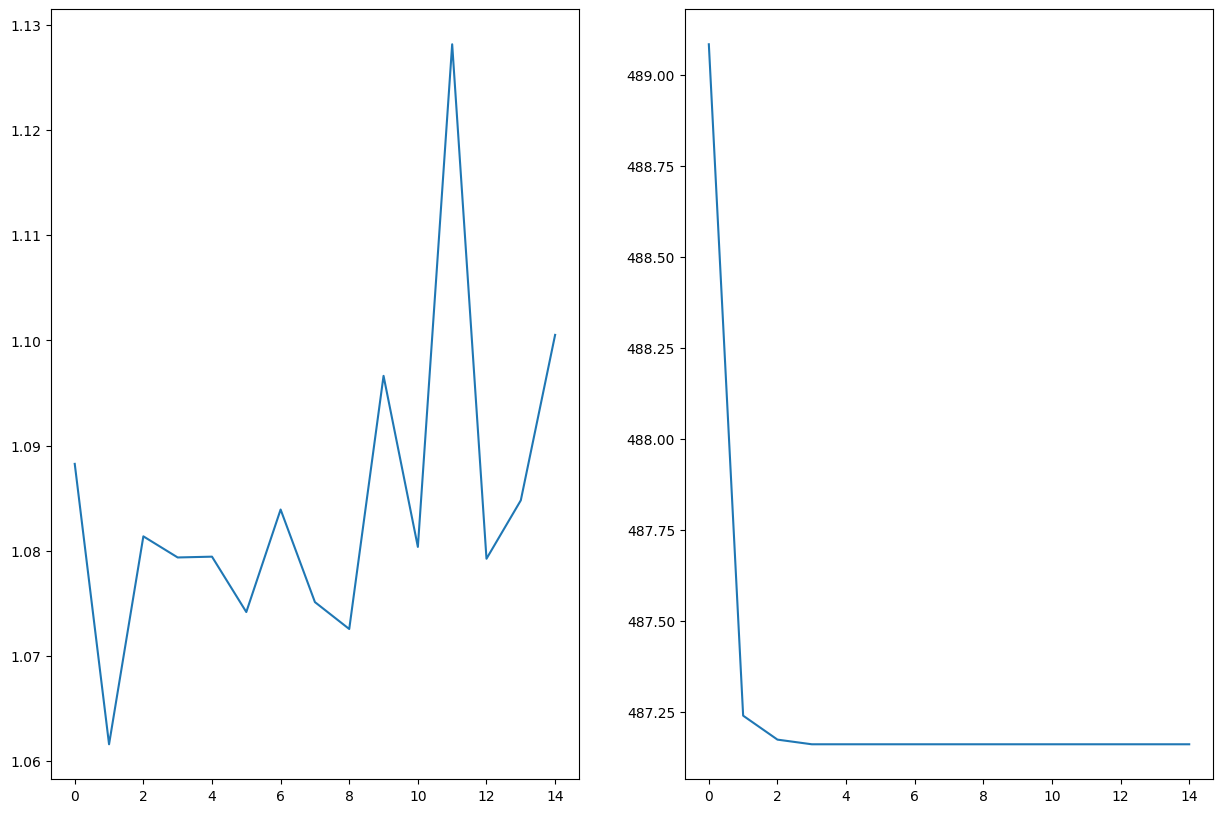

In [30]:
fig, ax=plt.subplots(1,2, figsize=(15,10))
ax[0].plot(logParallelKmeans["tIterations"])
ax[1].plot(logParallelKmeans["CostsKmeans"])

# AGREEMENT BETWEEN EXPECTED CLUSTER LABELS Y AND RESULTED LABELS CLUSTERLD

In [31]:
C_predicted=C
expectedRdd=Rdd.map(lambda datum:(labelToInt(datum[1]['y']), datum[1])) #put y-label as clusterId
C_expected=updateCentroids(expectedRdd) #compute centroids coordinate
expectedRdd=updateDistances(expectedRdd, C_expected) #update and save squared distances points-centroids
print(expectedRdd.take(1))

[(9, {'x': array([0.0, 0.016835785833143005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.9980392156862745, 0.9980392156862745, 0.0, 0.0, 0.0, 0.0,
       1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
      dtype=object), 'y': b'smurf.', 'd2': 8.776103527796696})]


First, we compare the cluster populations

predictedPopulationDict {0: 2840, 7: 918, 1: 369, 6: 334, 3: 218, 2: 99, 4: 67, 8: 52, 9: 47, 10: 37, 11: 10, 5: 9}


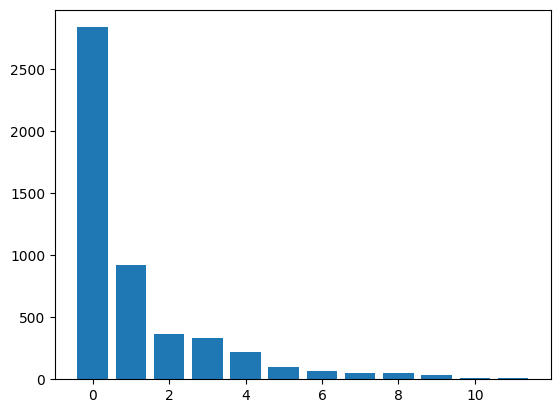

expectedPopulationDict {b'smurf.': 2840, b'neptune.': 1113, b'normal.': 956, b'back.': 33, b'satan.': 14, b'warezclient.': 12, b'ipsweep.': 9, b'teardrop.': 9, b'portsweep.': 7, b'nmap.': 4, b'pod.': 2, b'buffer_overflow.': 1}


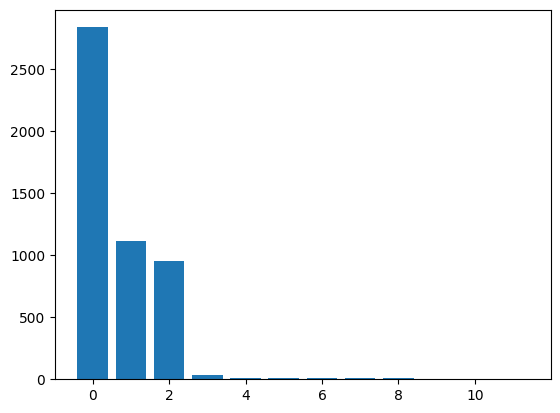

In [32]:
predictedPopulationDict=Rdd.countByKey()
predictedPopulationDict = dict(sorted(predictedPopulationDict.items(), key=lambda item: item[1], reverse=True))
expectedPopulationDict=Rdd.map(lambda datum:(datum[1]['y'], datum[1])).countByKey()
expectedPopulationDict = dict(sorted(expectedPopulationDict.items(), key=lambda item: item[1], reverse=True))
print('predictedPopulationDict', predictedPopulationDict)
plt.bar(np.arange(len(predictedPopulationDict)), predictedPopulationDict.values())
plt.show()
print('expectedPopulationDict',expectedPopulationDict)
plt.bar(np.arange(len(expectedPopulationDict)), expectedPopulationDict.values())
plt.show()

Now we want to calculate the mean square error between expected centroids and the nearest predicted centroids.

In [33]:
print('k_expected, k_predicted: ', len(C_expected), len(C_predicted))

labeler, distancesPredictedExpected=predictedCentroidsLabeler(C_expected, C_predicted)
meanSquaredError=np.sum(distancesPredictedExpected**2)/len(distancesPredictedExpected)
print('Index of nearest predicted centroid to each expected centroid: \n', labeler)
print('Distances between expected centroids and nearest predicted centroids: \n', distancesPredictedExpected)
print('MeanSquaredError: ', meanSquaredError)

k_expected, k_predicted:  12 12
Index of nearest predicted centroid to each expected centroid: 
 [7 1 3 9 8 9 0 1 7 3 2 9]
Distances between expected centroids and nearest predicted centroids: 
 [1.67511087 1.23806812 1.3390056  0.79165371 0.94252697 0.76814301
 0.         0.51488193 0.50858215 1.47205398 0.89481653 0.81247903]
MeanSquaredError:  1.0323651984593354


In [34]:
#standard deviation of cluster from expected centroids
#stdExpected=updateDistances(Rdd.map(lambda datum: (datum[1]['y'], datum[1])), C_expected).collect()
stdExpected=expectedRdd.mapValues(lambda datum1: (datum1['d2'], 1))\
                        .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1]))\
                        .mapValues(lambda a:np.sqrt(a[0]/a[1]))\
                        .collect()
stdExpected=list(zip(*stdExpected))
print(stdExpected)

[(4, 0, 8, 2, 10, 6, 9, 5, 3, 7, 11, 1), (2.5317350220952837, 3.244511749699696, 2.4099237859051135, 3.0480289333129167, 1.7793334656341129, 2.1130007253894325, 2.9592489534905035, 1.8505929836340498, 3.012100426499712, 2.6896502297778375, 1.3089615906576157, 1.9246290016415533)]


In the following plot we show:
- with blue errorbars the standard deviation of expected cluster with respect to expected centroids;
- with blue boxes the distances to each expected centroid of its nearest **expected** centroid
- with red bars the distances to each expected centroid of its nearest **predicted** centroid;

[1.67511087 1.23806812 1.3390056  0.79165371 0.94252697 0.76814301
 0.         0.51488193 0.50858215 1.47205398 0.89481653 0.81247903]


<BarContainer object of 12 artists>

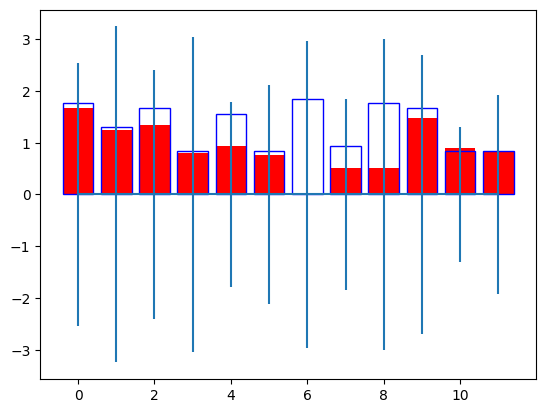

In [35]:
plt.errorbar(np.arange(len(C_expected)), np.zeros(shape=(len(stdExpected[0]))), stdExpected[1])
print(distancesPredictedExpected)
plt.bar(np.arange(len(C_expected)), distancesPredictedExpected, color='red')
plt.bar(np.arange(len(C_expected)), nearestCentroidDistances(C_expected)[1], edgecolor='blue', facecolor='none')

# BENCHMARKS

In [36]:
# select the pickle paths
pickle_fileP = 'dataP/log1P.pkl'
pickle_fileR = 'dataR/log1U.pkl'

In [37]:
# load the benchmark data 
with open(pickle_fileP, "rb") as file:
    logParallel = pickle.load(file)

with open(pickle_fileR, "rb") as file:
        logNaive = pickle.load(file)


In [38]:
# information about the parallel benchmark
logParallel

{'totalLogParallelInit': {'Number of partition1': {'tSamples': [0.08321571350097656,
    0.14698100090026855,
    0.22282767295837402,
    0.3588082790374756,
    0.4491755962371826,
    0.5802628993988037],
   'tCentroids': [0.13881349563598633,
    0.23493552207946777,
    0.35022759437561035,
    0.4490840435028076,
    0.5860741138458252,
    0.7492508888244629],
   'CostInit': [823.1009900744178,
    347.1856658304473,
    247.06864577820335,
    156.842953561549,
    149.51346088848717,
    137.35362393336464,
    124.08865127714856],
   'tTotal': 5.867350101470947},
  'Number of partition2': {'tSamples': [0.15071535110473633,
    0.21047139167785645,
    0.27449917793273926,
    0.36739039421081543,
    0.4932136535644531,
    0.650813102722168,
    0.6530303955078125],
   'tCentroids': [0.19458436965942383,
    0.27002716064453125,
    0.35074353218078613,
    0.4817647933959961,
    0.6489739418029785,
    1.1920928955078125e-06,
    0.8563973903656006],
   'CostInit': [1182.5

In [39]:
# information about the naive benchmark
logNaive

{'totalLogNaiveInit': {'Number of partition1': {'tTotal': 0.27451276779174805},
  'Number of partition2': {'tTotal': 0.49633097648620605}},
 'totalLogNaiveKmeans': {'Number of partition1': {'CostsKmeans': [501.25906355981874,
    459.11204302625094,
    445.1363300545453,
    436.8039766075408,
    433.89428659613617,
    433.29792226882233,
    433.14124937398293,
    433.11846468548725,
    432.7126346433218,
    432.50083689925134,
    432.47495454524045,
    432.4726496776249,
    432.470867325149,
    432.470867325149,
    432.470867325149],
   'tIterations': [0.30933308601379395,
    0.3904902935028076,
    0.4900245666503906,
    0.5928242206573486,
    0.6819806098937988,
    0.7736868858337402,
    0.8341593742370605,
    0.9377224445343018,
    1.0629732608795166,
    1.0988662242889404,
    1.2323634624481201,
    1.3276400566101074,
    1.4043469429016113,
    1.5013384819030762,
    1.538839340209961],
   'tTotal': 14.176602602005005},
  'Number of partition2': {'CostsKmea

### TESTING LOCAL KMEANS++ VS KMEANS// WITH A SMALL DATASET

In [155]:
# collect samples and features (target)
x = data[0]
y = data[1] 

In [156]:
# optional shuffling for better exploration of subset of dataset
shuffling=True
x
if shuffling:
    shuffled_indices = np.random.permutation(len(y))
    x=x[shuffled_indices]
    y=y[shuffled_indices]

In [157]:
# cut the data for memory reasons
subLen = 1000
x = x[:subLen,]
y = y[:subLen]

In [158]:
kTrue = len(np.unique(y))

In [159]:
k=kTrue

### First case - distributed - with initialization: kMeans//

In [160]:
# setting up some dictionaries
totalLogKmeansParallel = {}
totalLogInitParallel= {}
tDurationsParallel = {}
tPreOperationsParallel = {}

n_samples=5
for i_sample in range(n_samples):

    tInit = time() # compute the time of the beginning of the iteration
    print(f"The iteration n {i_sample} started at time {tInit}")
    
    # parallelize over nSlice partitions
    Rdd = sc.parallelize([(None, {"x": x[i],"y": y[i], "d2":None}) for i in range(len(y))])

    # cut the categorical attributes
    Rdd = Rdd.map(deleteBytes)\
             .persist()

    # setting the theoretical number of clusters
    kTrue = Rdd.map(lambda datum: datum[1]["y"])\
               .distinct()\
               .count()
    
    # rescale the RDD over the max
    maxS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.maximum(a, b))
    minS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.minimum(a, b))

    Rdd = Rdd.map(lambda datum: minmaxRescale(datum, minS, maxS))\
             .persist()
    
    # setting up the input and output information for the alghoritm
    logInit = {}
    logKmeans = {}

    k=kTrue
    l=k*2 # rescaling probability to have more centroids than k

    tInitI = time()

    tPreOperation = tInitI - tInit
    print(f"Finished the pre-steps after {tPreOperation} seconds")
          
    # initialization kMeans //
    C_init = parallelInit(Rdd, k, l, logInit)
    
    tInitialization = time() - tInitI
    print(f"Finished the initialization after {tInitialization} seconds")
    
    # run the k-means alghoritm
    C = kMeans(Rdd, C_init, 15, logKmeans)
    
    # time information
    tEnd = time() # compute the time of the end of the iteration over the number of partitions
    tDuration = tEnd - tInit
    
    print(f"The iteration with {nSlice} number of partition ended at time {tEnd} after {tDuration} seconds")

    # output in the correct memory adresses
    totalLogInitParallel[f"Sample n." + str(i_sample)] = logInit
    totalLogKmeansParallel[f"Sample n." + str(i_sample)] = logKmeans
    tDurationsParallel[f"Sample n." + str(i_sample)] = tDuration
    tPreOperationsParallel[f"Sample n." + str(i_sample)] = tPreOperation

The iteration n 0 started at time 1720197659.2282732
Finished the pre-steps after 0.7593021392822266 seconds


Finished the initialization after 8.492699146270752 seconds
The iteration with None number of partition ended at time 1720197678.6999722 after 19.471698999404907 seconds
The iteration n 1 started at time 1720197678.700042
Finished the pre-steps after 0.8038413524627686 seconds


Finished the initialization after 7.232735872268677 seconds
The iteration with None number of partition ended at time 1720197696.715538 after 18.015496015548706 seconds
The iteration n 2 started at time 1720197696.7156222
Finished the pre-steps after 0.7333149909973145 seconds


Finished the initialization after 8.799484968185425 seconds
The iteration with None number of partition ended at time 1720197716.5490947 after 19.83347249031067 seconds
The iteration n 3 started at time 1720197716.5491886
Finished the pre-steps after 0.7697112560272217 seconds


Finished the initialization after 7.373153448104858 seconds
The iteration with None number of partition ended at time 1720197734.7773104 after 18.228121757507324 seconds
The iteration n 4 started at time 1720197734.7774262
Finished the pre-steps after 0.7432205677032471 seconds


Finished the initialization after 7.6453537940979 seconds
The iteration with None number of partition ended at time 1720197753.507507 after 18.7300808429718 seconds


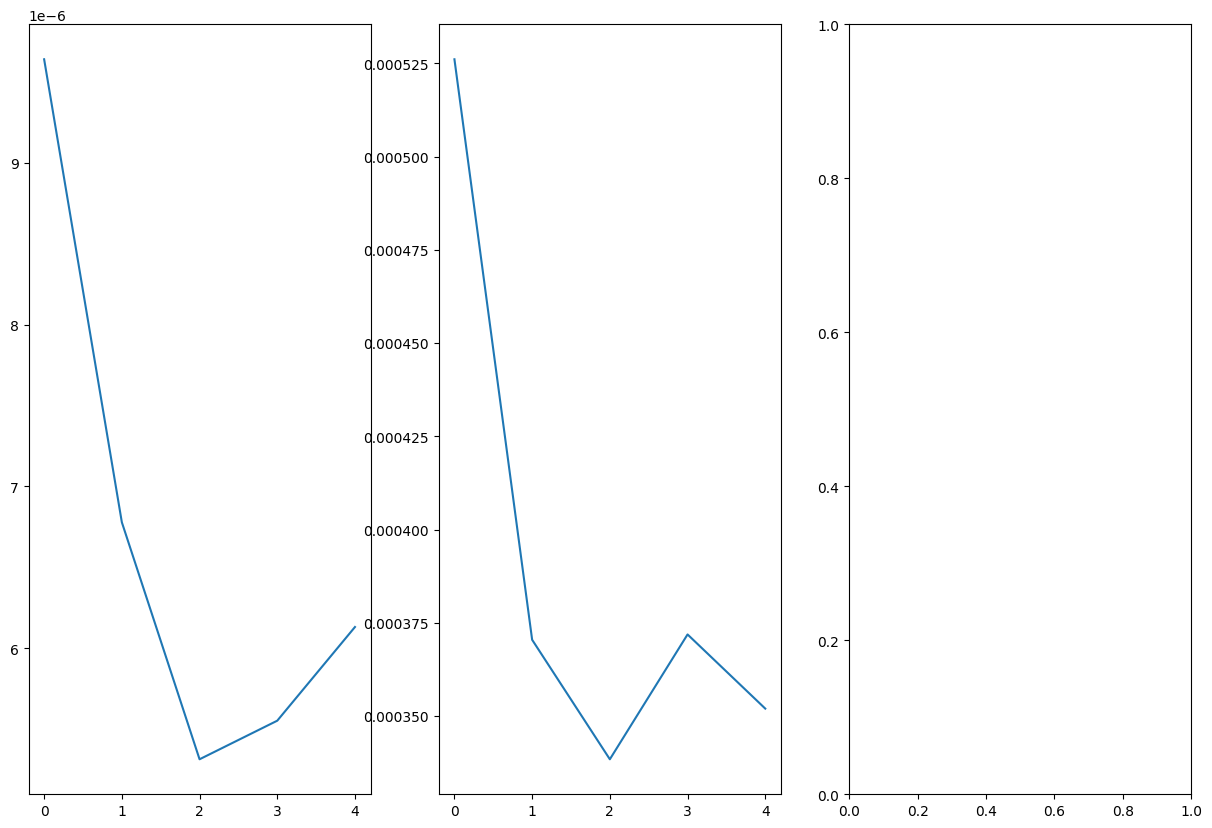

In [161]:
fig, ax=plt.subplots(1,3, figsize=(15,10))
ax[0].plot(np.array([totalLogInitPlusPlus[i]["tCentroids"] for i in range(n_samples)]).mean(axis=1))
ax[1].plot(np.array([totalLogInitPlusPlus[i]["tSamples"] for i in range(n_samples)]).mean(axis=1))
#ax[2].plot(logParallelInit["CostInit"])

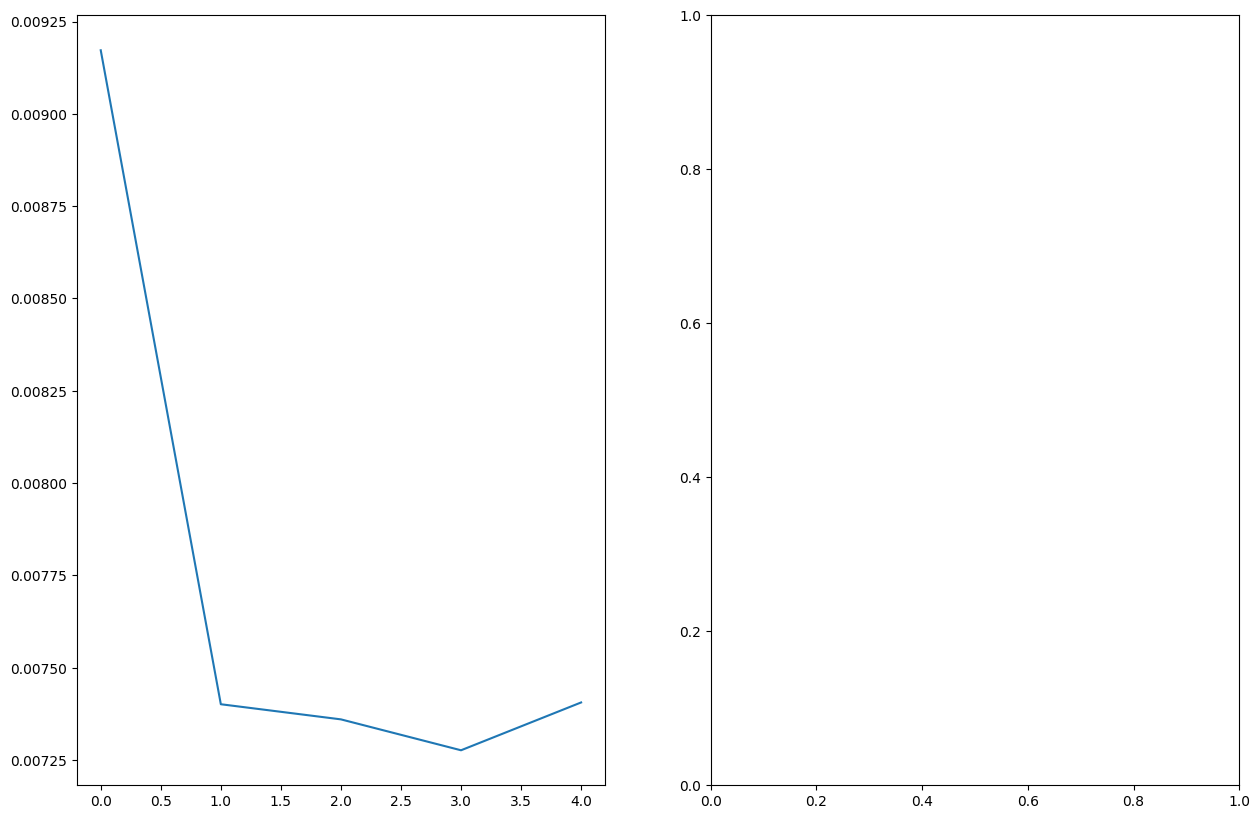

In [162]:
fig, ax=plt.subplots(1,2, figsize=(15,10))
ax[0].plot(np.array([totalLogKmeansPlusPlus[i]["tIterations"] for i in range(n_samples)]).mean(axis=1))
#ax[1].plot(logParallelKmeans["CostsKmeans"])

### Second case - local - with initialization: kMeans++

In [163]:
# setting up some dictionaries
totalLogKmeansPlusPlus = {}
totalLogInitPlusPlus= {}
tDurationsPlusPlus = {}
tPreOperationsPlusPlus = {}

n_samples=5
for i_sample in range(n_samples):

    tInit = time() # compute the time of the beginning of the iteration over the number of partitions
    print(f"The iteration with {nSlice} number of partition started at time {tInit}")
    
    # change format for processing
    localD =np.array([(None, {"x": x[i],"y": y[i], "d2":None}) for i in range(len(y))])

    # cut the categorical attributes

    localD =np.array(list(map(deleteBytes, localD)))
    
    localDX=np.array(list(map(lambda datum: datum[1]["x"], localD))).astype(float)
    
    # rescale the RDD over the max
    maxS = localDX.max(axis=0)
    minS = localDX.min(axis=0)

    localD = np.array(list(map(lambda datum: minmaxRescale(datum, minS, maxS), localD)))
    
    # setting up the input and output information for the alghoritm
    logInit = {}
    logKmeans = {}

    k=kTrue
    l=k*2 # rescaling probability to have more centroids than k

    tInitI = time()

    tPreOperation = tInitI - tInit
    print(f"Finished the pre-steps after {tPreOperation} seconds")
          
    # initialization kMeans //
    print(localDX.shape[0])
    C_init = localPlusPlusInit(localDX, k, logInit)
    
    tInitialization = time() - tInitI
    print(f"Finished the initialization after {tInitialization} seconds")
    
    # run the k-means alghoritm
    C =  localLloyds(localDX, k, C_init=C_init, n_iterations=100, logDict=logKmeans)
    
    # time information
    tEnd = time() # compute the time of the end of the iteration over the number of partitions
    tDuration = tEnd - tInit
    
    print(f"The iteration n. {i_sample} ended at time {tEnd} after {tDuration} seconds")

    # output in the correct memory adresses
    totalLogInitPlusPlus[i_sample] = logInit
    totalLogKmeansPlusPlus[i_sample] = logKmeans
    tDurationsPlusPlus[i_sample] = tDuration
    tPreOperationsPlusPlus[i_sample] = tPreOperation

The iteration with None number of partition started at time 1720197753.9111724
Finished the pre-steps after 0.018218040466308594 seconds
1000
Finished the initialization after 0.0038237571716308594 seconds
The iteration n. 0 ended at time 1720197754.8431997 after 0.9320273399353027 seconds
The iteration with None number of partition started at time 1720197754.8432682
Finished the pre-steps after 0.016501188278198242 seconds
1000
Finished the initialization after 0.0037391185760498047 seconds
The iteration n. 1 ended at time 1720197755.7619321 after 0.9186639785766602 seconds
The iteration with None number of partition started at time 1720197755.7620025
Finished the pre-steps after 0.017307043075561523 seconds
1000
Finished the initialization after 0.004348278045654297 seconds
The iteration n. 2 ended at time 1720197756.6807134 after 0.9187109470367432 seconds
The iteration with None number of partition started at time 1720197756.6807845
Finished the pre-steps after 0.01833796501159668 

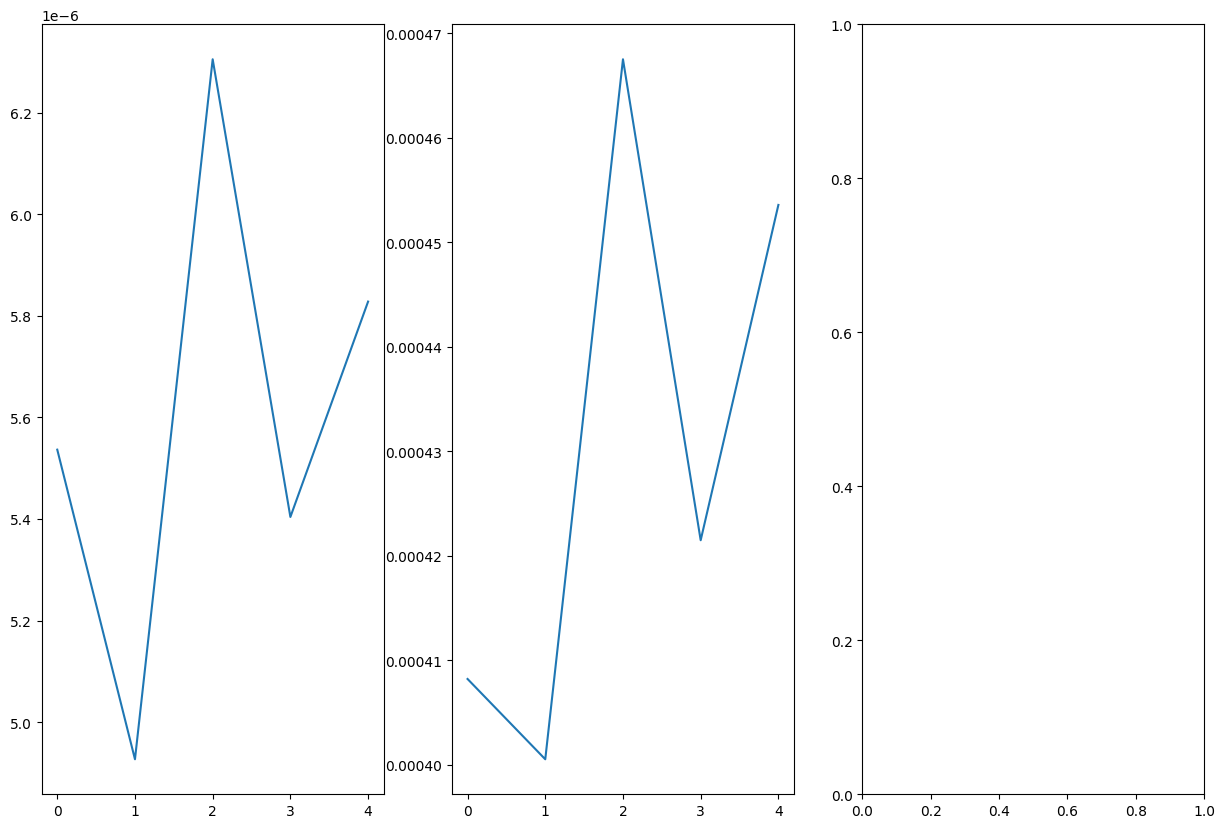

In [164]:
fig, ax=plt.subplots(1,3, figsize=(15,10))
ax[0].plot(np.array([totalLogInitPlusPlus[i]["tCentroids"] for i in range(n_samples)]).mean(axis=1))
ax[1].plot(np.array([totalLogInitPlusPlus[i]["tSamples"] for i in range(n_samples)]).mean(axis=1))
#ax[2].plot(logParallelInit["CostInit"])

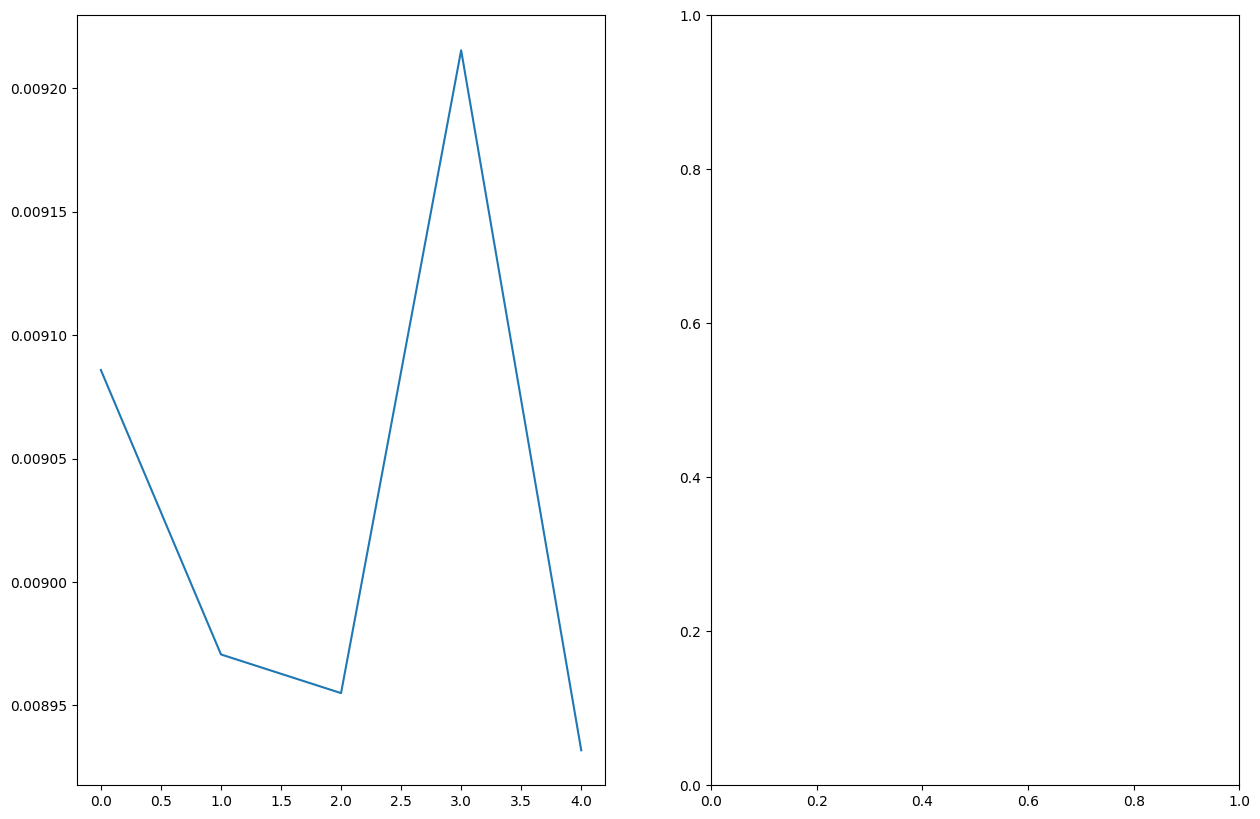

In [165]:
fig, ax=plt.subplots(1,2, figsize=(15,10))
ax[0].plot(np.array([totalLogKmeansPlusPlus[i]["tIterations"] for i in range(n_samples)]).mean(axis=1))
#ax[1].plot(logParallelKmeans["CostsKmeans"])